In [20]:
import networkx
from operator import itemgetter
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
amazonBooks = pd.read_csv('./amazon-books.csv', index_col=0)

In [22]:
fhr=open("amazon-books-copurchase.edgelist", 'rb')
copurchaseGraph=networkx.read_weighted_edgelist(fhr)
fhr.close()

In [23]:
print ("Looking for Recommendations for Customer Purchasing this Book:")
print ("--------------------------------------------------------------")
purchasedAsin = '0805047905'

# Let's first get some metadata associated with this book
print ("ASIN = ", purchasedAsin) 
print ("Title = ", amazonBooks.loc[purchasedAsin,'Title'])
print ("SalesRank = ", amazonBooks.loc[purchasedAsin,'SalesRank'])
print ("TotalReviews = ", amazonBooks.loc[purchasedAsin,'TotalReviews'])
print ("AvgRating = ", amazonBooks.loc[purchasedAsin,'AvgRating'])
print ("DegreeCentrality = ", amazonBooks.loc[purchasedAsin,'DegreeCentrality'])
print ("ClusteringCoeff = ", amazonBooks.loc[purchasedAsin,'ClusteringCoeff'])

Looking for Recommendations for Customer Purchasing this Book:
--------------------------------------------------------------
ASIN =  0805047905
Title =  Brown Bear, Brown Bear, What Do You See?
SalesRank =  171
TotalReviews =  172
AvgRating =  5.0
DegreeCentrality =  216
ClusteringCoeff =  0.01976744186046512


In [24]:
purchasedAsinEgoGraph = networkx.Graph(networkx.ego_graph(copurchaseGraph, purchasedAsin, radius=1))

In [25]:
threshold = 0.5
purchasedAsinEgoTrimGraph = networkx.Graph()
for f, t, e in purchasedAsinEgoGraph.edges(data=True):
    if e['weight'] > threshold:
        purchasedAsinEgoTrimGraph.add_edge(f,t,weight=e['weight'])

In [26]:
purchasedAsinNeighbors = [i for i in purchasedAsinEgoTrimGraph.neighbors(purchasedAsin)] 


C:\Users\Nikita Dodda\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


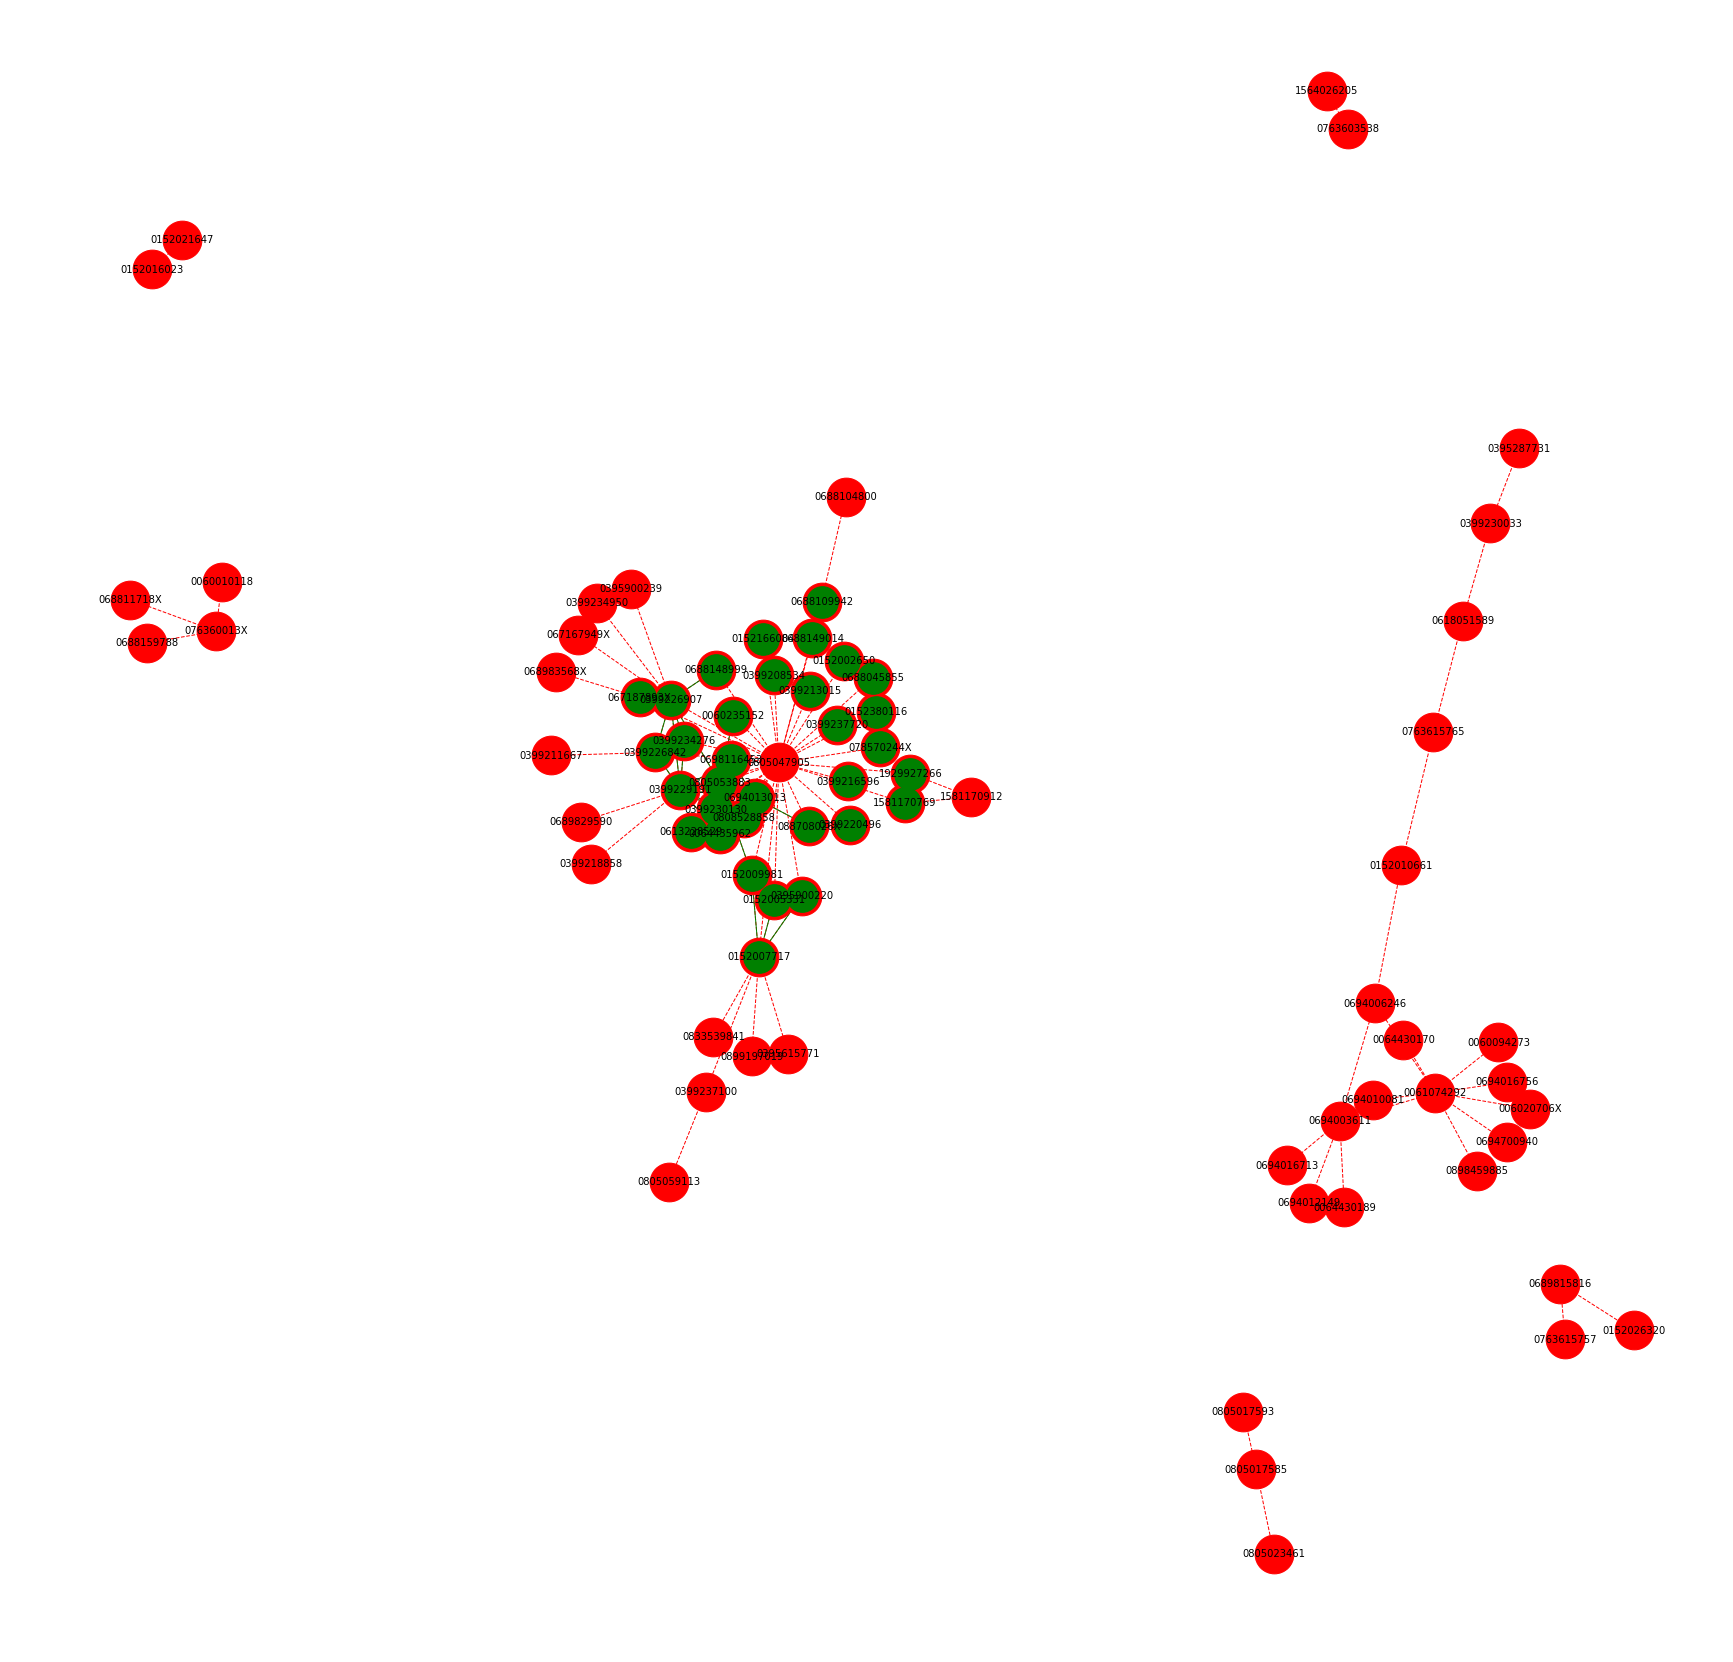

In [27]:
subgraph=purchasedAsinEgoTrimGraph.subgraph(purchasedAsinNeighbors)
pos = networkx.spring_layout(purchasedAsinEgoTrimGraph)  
plt.figure(figsize=(30,30))
networkx.draw_networkx_labels(purchasedAsinEgoTrimGraph,pos,font_size=10)
networkx.draw(purchasedAsinEgoTrimGraph, pos=pos, node_size=1500, node_color='r', edge_color='r', style='dashed')
networkx.draw(subgraph, pos=pos, node_size=1000, node_color='g', edge_color='g', style='solid')
plt.show()

In [28]:
y=purchasedAsinEgoTrimGraph.edges.data()

z=[]
for i  in y:
    if i[0]==purchasedAsin or i[1]== purchasedAsin:
        if i[0] in purchasedAsinNeighbors or i[1] in purchasedAsinNeighbors:
            z.append(i)
purchasedAsinNeighbors_weight=[]
for i in z:
    if i[0]==purchasedAsin:
        purchasedAsinNeighbors_weight.append((i[1],i[2]["weight"]))
    else:
        purchasedAsinNeighbors_weight.append((i[0],i[2]["weight"]))


In [29]:
purchasedAsinNeighbors_AvgRating=[]
purchasedAsinNeighbors_SalesRank=[]
purchasedAsinNeighbors_TotalReviews=[]
purchasedAsinNeighbors_Title=[]
purchasedAsinNeighbors_DegreeCentrality=[]
purchasedAsinNeighbors_ClusteringCoeff=[]

for i in purchasedAsinNeighbors:
        purchasedAsinNeighbors_AvgRating.append((i,amazonBooks.loc[i,'AvgRating']))
        purchasedAsinNeighbors_SalesRank.append((i,amazonBooks.loc[i,'SalesRank']))
        purchasedAsinNeighbors_TotalReviews.append((i,amazonBooks.loc[i,'TotalReviews']))
        purchasedAsinNeighbors_Title.append((i,amazonBooks.loc[i,'Title']))
        purchasedAsinNeighbors_DegreeCentrality.append((i,amazonBooks.loc[i,'DegreeCentrality']))
        purchasedAsinNeighbors_ClusteringCoeff.append((i,amazonBooks.loc[i,'ClusteringCoeff']))


df1 = pd.DataFrame(purchasedAsinNeighbors_weight, columns =["Asin","Weight"]) 
df2 = pd.DataFrame(purchasedAsinNeighbors_AvgRating, columns =["Asin","AvgRating"]) 
df3 = pd.DataFrame(purchasedAsinNeighbors_SalesRank, columns =["Asin","SalesRank"]) 
df4 = pd.DataFrame(purchasedAsinNeighbors_TotalReviews, columns =["Asin","TotalReviews"])
df5 = pd.DataFrame(purchasedAsinNeighbors_Title, columns =["Asin","Title"])
df6 = pd.DataFrame(purchasedAsinNeighbors_DegreeCentrality, columns =["Asin","DegreeCentrality"])
df7 = pd.DataFrame(purchasedAsinNeighbors_ClusteringCoeff, columns =["Asin","ClusteringCoeff"])

df=pd.merge(df1,df5,how="outer",on="Asin")
df=pd.merge(df,df3,how="outer",on="Asin")
df=pd.merge(df,df4,how="outer",on="Asin")
df=pd.merge(df,df2,how="outer",on="Asin")
df=pd.merge(df,df6,how="outer",on="Asin")
df=pd.merge(df,df7,how="outer",on="Asin")


In [30]:
# from sklearn.preprocessing import MinMaxScaler
# num_vars=["TotalReviews","SalesRank"]
# mms=MinMaxScaler()
# dfnum=pd.DataFrame(mms.fit_transform(df[num_vars]),columns=["mms_"+x for x in num_vars])
# df=pd.concat([df,dfnum],axis=1)

# df["composite measure"]=df["Weight"]*(df["mms_TotalReviews"]*df["AvgRating"])/(df["mms_SalesRank"]+1)


In [31]:
# sorteddf=df.sort_values(by=["composite measure"],ascending=False)


In [32]:
# sorteddf=df.drop(["mms_TotalReviews","mms_SalesRank"],axis=1)
# print(sorteddf.loc[0:5,:])

In [33]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
mms=MinMaxScaler()
df["mms_SalesRank"]=pd.DataFrame(mms.fit_transform(df[["SalesRank"]]),index=df.index)
df["exp_TotalReviews"] = 1-np.exp(-df["TotalReviews"]/50)
df

C:\Users\Nikita Dodda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Asin,Weight,Title,SalesRank,TotalReviews,AvgRating,DegreeCentrality,ClusteringCoeff,mms_SalesRank,exp_TotalReviews
0,0688109942,0.56,Have You Seen My Duckling?,96210,8,5.0,10,0.200000,0.076223,0.147856
1,0060235152,0.54,From Head to Toe,43438,22,5.0,5,0.900000,0.034292,0.355964
2,0399226842,0.67,The Very Quiet Cricket Board Book,4955,26,4.5,23,0.233202,0.003715,0.405479
3,0395900220,0.52,Mary Wore Her Red Dress and Henry Wore His Gre...,416184,3,5.0,5,0.500000,0.330461,0.058235
4,0399220496,0.69,The Very Hungry Caterpillar Book with Plush Ca...,181105,164,4.5,5,1.000000,0.143677,0.962372
5,0399208534,0.68,The Very Hungry Caterpillar,2117,164,4.5,5,1.000000,0.001460,0.962372
6,0152380116,0.56,I Went Walking (A Voyager/Hbj Book),149838,15,4.5,5,0.700000,0.118834,0.259182
7,0399229191,0.62,The Very Busy Spider (Board Book),2558,27,4.5,49,0.096088,0.001811,0.417252
8,0688148999,0.55,Have You Seen My Duckling?,280258,8,5.0,5,0.400000,0.222460,0.147856
9,0399234276,0.51,The Very Lonely Firefly board book (Board Book),11490,24,4.0,21,0.276190,0.008908,0.381217


In [34]:
df["composite measure"]=df["Weight"]*(df["exp_TotalReviews"]*df["AvgRating"])/(df["mms_SalesRank"]+1)
df 

,Asin,Weight,Title,SalesRank,TotalReviews,AvgRating,DegreeCentrality,ClusteringCoeff,mms_SalesRank,exp_TotalReviews,composite measure
0,0688109942,0.56,Have You Seen My Duckling?,96210,8,5.0,10,0.200000,0.076223,0.147856,0.384676
1,0060235152,0.54,From Head to Toe,43438,22,5.0,5,0.900000,0.034292,0.355964,0.929236
2,0399226842,0.67,The Very Quiet Cricket Board Book,4955,26,4.5,23,0.233202,0.003715,0.405479,1.217995
3,0395900220,0.52,Mary Wore Her Red Dress and Henry Wore His Gre...,416184,3,5.0,5,0.500000,0.330461,0.058235,0.113804
4,0399220496,0.69,The Very Hungry Caterpillar Book with Plush Ca...,181105,164,4.5,5,1.000000,0.143677,0.962372,2.612769
5,0399208534,0.68,The Very Hungry Caterpillar,2117,164,4.5,5,1.000000,0.001460,0.962372,2.940563
6,0152380116,0.56,I Went Walking (A Voyager/Hbj Book),149838,15,4.5,5,0.700000,0.118834,0.259182,0.583767
7,0399229191,0.62,The Very Busy Spider (Board Book),2558,27,4.5,49,0.096088,0.001811,0.417252,1.162028
8,0688148999,0.55,Have You Seen My Duckling?,280258,8,5.0,5,0.400000,0.222460,0.147856,0.332612
9,0399234276,0.51,The Very Lonely Firefly board book (Board Book),11490,24,4.0,21,0.276190,0.008908,0.381217,0.770816


In [35]:
sorteddf=df.sort_values(by=["composite measure"],ascending=False)
sorteddf

,Asin,Weight,Title,SalesRank,TotalReviews,AvgRating,DegreeCentrality,ClusteringCoeff,mms_SalesRank,exp_TotalReviews,composite measure
21,0399226907,0.75,The Very Hungry Caterpillar board book,279,164,4.5,116,0.038681,0.000000,0.962372,3.248005
5,0399208534,0.68,The Very Hungry Caterpillar,2117,164,4.5,5,1.000000,0.001460,0.962372,2.940563
15,0399237720,0.67,Very Hungry Caterpillar Giant Board Book and P...,112356,164,4.5,5,1.000000,0.089052,0.962372,2.664291
4,0399220496,0.69,The Very Hungry Caterpillar Book with Plush Ca...,181105,164,4.5,5,1.000000,0.143677,0.962372,2.612769
12,0399216596,0.71,Very Hungry Caterpillar Plush Toy (Toy Only),467296,164,4.5,5,1.000000,0.371073,0.962372,2.242607
20,0399213015,0.69,The Very Hungry Caterpillar (MINIATURE EDITION),431501,164,4.5,5,1.000000,0.342632,0.962372,2.225603
24,0805053883,0.78,"Polar Bear, Polar Bear, What Do You Hear?",2515,29,4.5,42,0.070848,0.001777,0.440102,1.542017
26,0694013013,0.70,From Head to Toe Board Book,6026,22,5.0,48,0.071809,0.004566,0.355964,1.240209
19,1581170769,0.58,What Makes a Rainbow?: Pop-Up,40821,29,5.0,7,0.238095,0.032213,0.440102,1.236464
2,0399226842,0.67,The Very Quiet Cricket Board Book,4955,26,4.5,23,0.233202,0.003715,0.405479,1.217995


In [36]:
sorteddf=sorteddf.drop(["exp_TotalReviews","mms_SalesRank","Weight","composite measure"],axis=1)
sorteddf
#print(sorteddf.loc[0:5,:])

,Asin,Title,SalesRank,TotalReviews,AvgRating,DegreeCentrality,ClusteringCoeff
21,0399226907,The Very Hungry Caterpillar board book,279,164,4.5,116,0.038681
5,0399208534,The Very Hungry Caterpillar,2117,164,4.5,5,1.000000
15,0399237720,Very Hungry Caterpillar Giant Board Book and P...,112356,164,4.5,5,1.000000
4,0399220496,The Very Hungry Caterpillar Book with Plush Ca...,181105,164,4.5,5,1.000000
12,0399216596,Very Hungry Caterpillar Plush Toy (Toy Only),467296,164,4.5,5,1.000000
20,0399213015,The Very Hungry Caterpillar (MINIATURE EDITION),431501,164,4.5,5,1.000000
24,0805053883,"Polar Bear, Polar Bear, What Do You Hear?",2515,29,4.5,42,0.070848
26,0694013013,From Head to Toe Board Book,6026,22,5.0,48,0.071809
19,1581170769,What Makes a Rainbow?: Pop-Up,40821,29,5.0,7,0.238095
2,0399226842,The Very Quiet Cricket Board Book,4955,26,4.5,23,0.233202


In [37]:
sorteddf=sorteddf.reset_index(drop=True)

In [38]:
sorteddf.loc[:5,:]

,Asin,Title,SalesRank,TotalReviews,AvgRating,DegreeCentrality,ClusteringCoeff
0,0399226907,The Very Hungry Caterpillar board book,279,164,4.5,116,0.038681
1,0399208534,The Very Hungry Caterpillar,2117,164,4.5,5,1.000000
2,0399237720,Very Hungry Caterpillar Giant Board Book and P...,112356,164,4.5,5,1.000000
3,0399220496,The Very Hungry Caterpillar Book with Plush Ca...,181105,164,4.5,5,1.000000
4,0399216596,Very Hungry Caterpillar Plush Toy (Toy Only),467296,164,4.5,5,1.000000
5,0399213015,The Very Hungry Caterpillar (MINIATURE EDITION),431501,164,4.5,5,1.000000
